# Model training



In [1]:
from config import *
import torch

from OFDM_SDR_Functions_torch import *
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as tFunc # usually F, but that is reserved for other use
import csv
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataloader
Load dataset created earlier and make the torch dataloaders. The dataset structure is defined in the config.py file.

In [2]:
dataset = CustomDataset()
dataset = torch.load('data/ofdm_dataset.pth')
saved_model_path = 'data/rx_model.pth'

batch_size = 32

# train, validation and test split
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)




## NN-receiver model
Create a torch model for the receiver. The structure follows loosely the DeepRX (https://arxiv.org/abs/2005.01494) structure, but is simplified and lighter. The model architecture is stored in `models_local.py`. 

In [ ]:
from models_local import *

model = RXModel(Qm).to(device)

## Model training

Set the optimizer and loss function

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

Load earlier model for further training or start from scratch 

In [ ]:
saved_model_path = 'data/rx_model_50.pth'
performance_csv_path = 'data/performance_details.csv'
num_epochs = 200

# Check if a saved model exists
if os.path.exists(saved_model_path):
    # Load the existing model and epoch
    checkpoint = torch.load(saved_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Existing model loaded from {saved_model_path}, Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("No saved model found. Training from scratch.")



Model performance data

In [ ]:
# Lists to store performance details for plotting
train_losses = []
val_losses = []
val_BERs = []

# Check if a performance CSV file exists
if not os.path.exists(performance_csv_path):
    # Create a new CSV file and write headers
    with open(performance_csv_path, mode='w', newline='') as csv_file:
        fieldnames = ['Epoch', 'Training Loss', 'Validation Loss', 'Validation BER']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()


Training loop

In [ ]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0

    for pdsch_iq, pilot_iq, labels in train_loader:
        pdsch_iq, pilot_iq, labels = pdsch_iq.to(device), pilot_iq.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model((pdsch_iq, pilot_iq))  # forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for val_pdsch_iq, val_pilot_iq, val_labels in val_loader:
            val_pdsch_iq, val_pilot_iq, val_labels = val_pdsch_iq.to(device), val_pilot_iq.to(device), val_labels.to(device)
            val_outputs = model((val_pdsch_iq, val_pilot_iq))
            val_loss = criterion(val_outputs, val_labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != val_labels).float()  # Count of unequal bits
            error_rate = error_count / len(val_labels.flatten())  # Error rate calculation
            BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

    model.train()  # Set the model back to training mode

    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    val_BERs.append(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER:.4f}")

    # Save performance details in the CSV file
    with open(performance_csv_path, mode='a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([epoch + 1, average_loss, val_loss.item(), BER.item()])

    if (epoch + 1) % 5 == 0:
        # Save model along with the current epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }
        torch.save(checkpoint, f'data/rx_model_{epoch + 1}.pth')
        print(f"Model saved at epoch {epoch + 1}")

# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
torch.save(checkpoint, 'data/rx_model.pth')


```
Epoch [1/200], Loss: 0.6304, Val Loss: 0.4400, Val BER: 0.2750
Epoch [2/200], Loss: 0.3430, Val Loss: 0.3007, Val BER: 0.1550
Epoch [3/200], Loss: 0.2569, Val Loss: 0.2430, Val BER: 0.1120
Epoch [4/200], Loss: 0.2190, Val Loss: 0.2223, Val BER: 0.1040
Epoch [5/200], Loss: 0.2046, Val Loss: 0.1963, Val BER: 0.0880
Model saved at epoch 5
Epoch [6/200], Loss: 0.1952, Val Loss: 0.2064, Val BER: 0.0910
Epoch [7/200], Loss: 0.1879, Val Loss: 0.1981, Val BER: 0.0900
Epoch [8/200], Loss: 0.1827, Val Loss: 0.1920, Val BER: 0.0880
Epoch [9/200], Loss: 0.1781, Val Loss: 0.1711, Val BER: 0.0750
Epoch [10/200], Loss: 0.1731, Val Loss: 0.1966, Val BER: 0.0900
Model saved at epoch 10
Epoch [11/200], Loss: 0.1692, Val Loss: 0.1921, Val BER: 0.0860
...

## Model performance during training
Visualize the performance during training

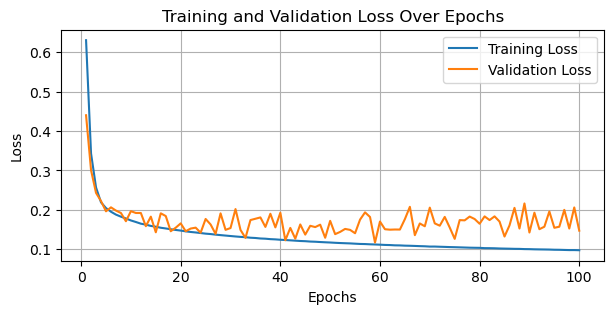

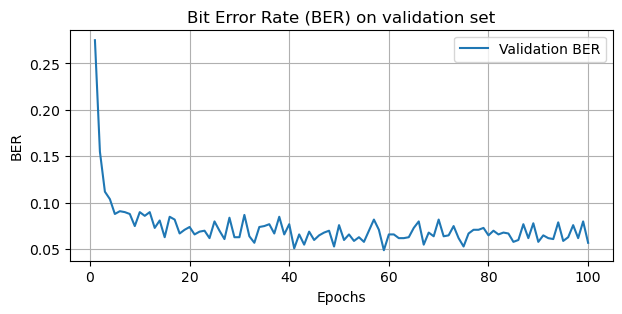

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV data
csv_path = 'data/performance_details.csv'
df = pd.read_csv(csv_path)

# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.show()

# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(df['Epoch'], df['Validation BER'], label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)
plt.show()